# Modern Data Science 
**(Module 03: Pattern Classification)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.

Prepared by and for 
**Student Members** |
2006-2018 [TULIP Lab](http://www.tulip.org.au), Australia

---


# Session A - Bayesian 

In this session, it contains four parts contents: the first part is estimating model parameters, the second part is model checking, the third part is hierarchal modeling, the fourth part is bayesian regression.

## Part 1: Estimating model parameters
In this part we will discuss how Bayesians think about data, and how we can estimate model parameters using a technique called MCMC.

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
from statsmodels import api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### How do Bayesians think about data?
When I started to learn how to apply Bayesian methods, I found it very useful to understand how Bayesians think about data. Imagine the following scenario:
> A curious boy watches the number of cars that pass by his house every day. He diligently notes down the total count of cars that pass per day. Over the past week, his notebook contains the following counts: 12, 33, 20, 29, 20, 30, 18

From a Bayesian's perspective, this data is generated by a random process. However, now that the data is observed, it is fixed and does not change. This random process has some model parameters that are fixed. However, the Bayesian uses probability distributions to represent his/her uncertainty in these parameters.

Because the boy is measuring counts (non-negative integers), it is common practice to use a Poisson distribution to model the data (eg. the random process). A Poisson distribution takes a single parameter $\mu$ which describes both the mean and variance of the data. You can see 3 Poisson distributions below with different values of $\mu$.

$$p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for     } 
x = 0, 1, 2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$

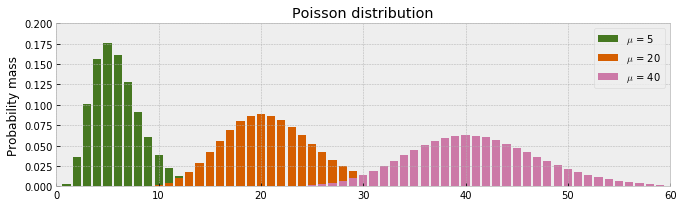

In [2]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

In the previous section we imported my hangout chat dataset. I'm particularly interested in the time it takes me to respond to messages (`response_time`). Given that `response_time` is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$. We will explore both a frequentist and Bayesian method of estimating this parameter.

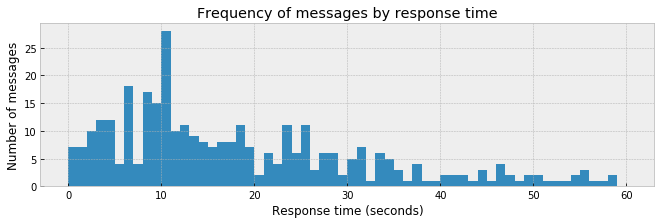

In [3]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

### Frequentists method of estimating $\mu$
Before we jump into Bayesian techniques, lets first look at a frequentist method of estimating the parameters of a Poisson distribution. We will use an optimization technique that aims to maximize the likelihood of a function.

The below function `poisson_logprob()` returns the overall likelihood of the observed data given a Poisson model and parameter value. We use the method `opt.minimize_scalar` to find the value of $\mu$ that is most credible (maximizes the log likelihood) given the data observed. Under the hood, this optimization technique is intelligently iterating through possible values of `mu` until it finds a value with the highest likelihood.

In [4]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.2307692324
Wall time: 2 ms


So, the estimate of the value of $\mu$ is 18.0413533867. The optimization technique doesn't provide any measure of uncertainty - it just returns a point value. And it does so very efficiently...

The below plot illustrates the function that we are optimizing. At each value of $\mu$, the plot shows the log probability at $\mu$ given the data and the model. The optimizer works in a hill climbing fashion - starting at a random point on the curve and incrementally climbing until it cannot get to a higher point.

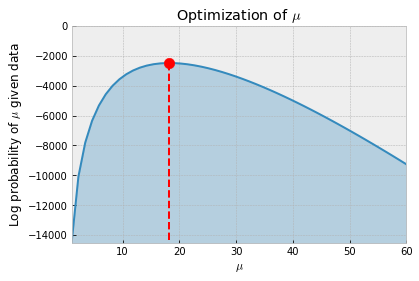

In [5]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

The above optimization has estimated the parameter ($\mu$) of a Poisson model to be 18. We know for any Poisson distribution, the parameter $\mu$ represents both its mean and variance. The below plot illustrates this distribution.

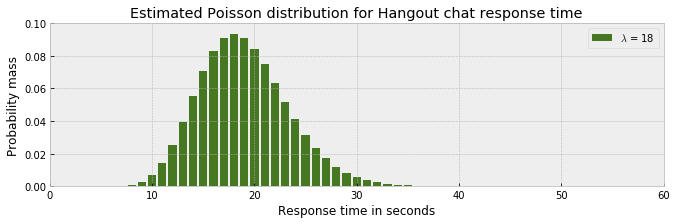

In [6]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

The above Poisson model and estimated value of $\mu$ suggest that there is minimal chance of an observation less than 10 or greater than 30. The vast majority of the probability mass is between 10 and 30. However, we know this is not reflected in the data that we observed - which has observed values between 0 and 60.

### Bayesian method of estimating $\mu$

If you've encountered Bayes' theorem before, the below formula will look familiar. This framework never resonated with me until I read John K. Kruschke's book "Doing Bayesian Data Analysis" and saw the below formula through the lens of his beautifully simple Bayesian graphical models.
 
$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

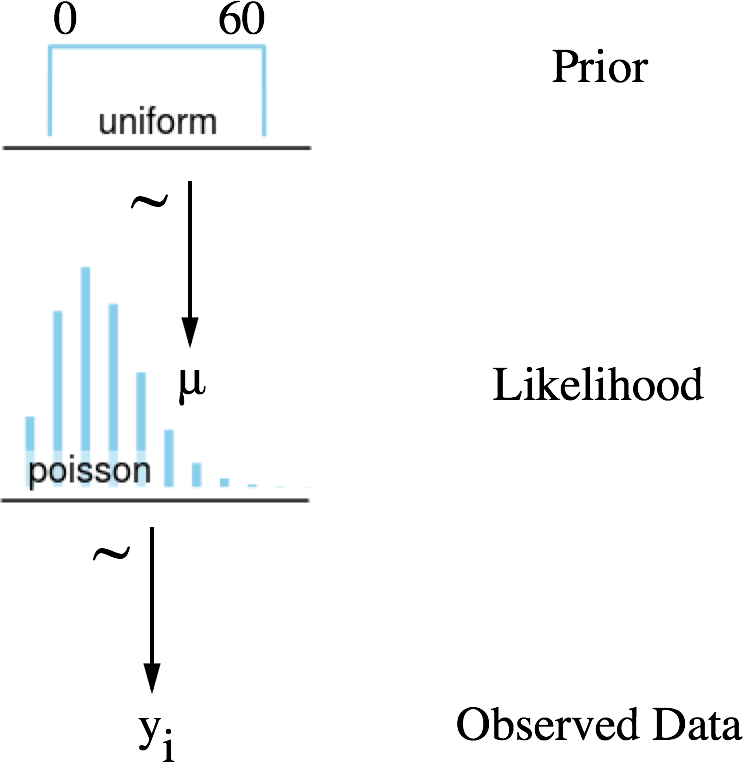

In [8]:
Image('image/Poisson-dag.png', width=320)

The above schema can be interpreted as follows (from the bottom up):
- We observe counts of data (y) for each conversation i (Observed Data)
- This data was generated by a random process which we believe can be represented as a Poisson distribution (Likelihood)
- This Poisson distribution has a single parameter $\mu$ which we know is between 0 and 60 (Prior)
  - We will model $\mu$ as a uniform distribution because we do not have an opinion as to where within this range to expect it

### The magical mechanics of MCMC
The process of Markov Chain Monte Carlo (MCMC) is nicely illustrated in the below animation. The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values. 

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

This calculation acts as a guiding light for the MCMC sampler. As it draws values from the paramater priors, it computes the likelihood of these paramters given the data - and will try to guide the sampler towards areas of higher probability.

In a conceptually similar manner to the frequentist optimization technique discussed above, the MCMC sampler wanders towards areas of highest likelihood. However, the Bayesian method is not concerned with findings the absolute maximum values - but rather to traverse and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [9]:
Image(url='image/mcmc-animate.gif')

In [10]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

logp = -3,398.7, ||grad|| = 1,989: 100%|████████| 7/7 [00:00<00:00, 233.33it/s]


The above code has just gathered 200,000 credible samples of $\mu$ by traversing over the areas of high likelihood of the posterior distribution of $\mu$. The below plot (left) shows the distribution of values collected for $\mu$. The mean of this distribution is almost identical to the frequentist estimate (red line). However, we also get a measure of uncertainty and can see that there are credible values of $\mu$ between 17 and 19. This measure of uncertainty is incredibly valuable as we will see later.

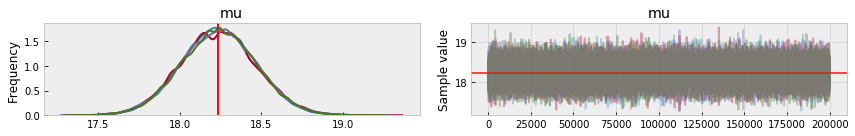

In [11]:
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

### Discarding early samples (burnin)
You may have wondered what the purpose of `pm.find_MAP()` is in the above MCMC code. MAP stands for maximum a posteriori estimation. It helps the MCMC sampler find a good place from which to start sampling. Ideally this will start the model off in an area of high likelihood - but sometimes that doesn't happen. As a result, the samples collected early in the trace (burnin samples) are often discarded.

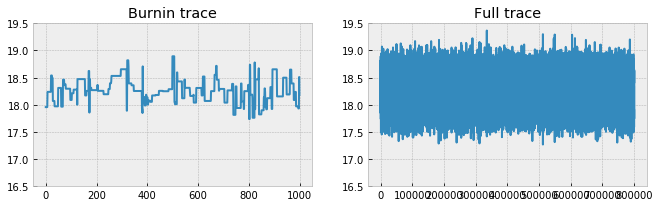

In [12]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu'))

### Model convergence
#### Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.

#### Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.

Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

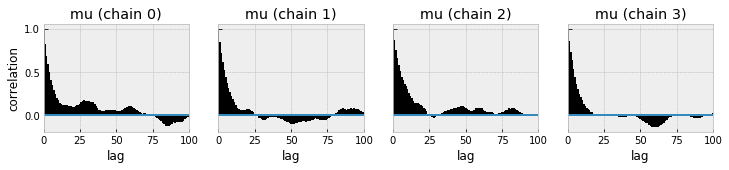

In [13]:
_ = pm.autocorrplot(trace[:2000], varnames=['mu'])

## Part 2: Model checking
In this part, we will look at two techniques that aim to answer:
1. Are the model and parameters estimated a good fit for the underlying data?
2. Given two separate models, which is a better fit for the underlying data?

----

### Model Check I: Posterior predictive check
One method of checking model fit is called the posterior predictive check. I find this to be a very intuitive technique. You'll recall in the previous section we estimated the parameter $\mu$ of a Poisson distribution by collecting 200,000 samples from the posterior distribution of $\mu$. Each of these samples was considered to be a credible parameter value.

The posterior predictive check requires one to generate new data from the predicted model. What does that mean? Well, we have estimated 200,000 credible values of $\mu$ for the Poisson distribution. That means we can construct 200,000 Poisson distributions with these values and then randomly sample from these distributions. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Conceptually, if the model is a good fit for the underlying data - then the generated data should resemble the original observed data. PyMC provides a convenient way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

This is almost identical to `y_est` except we do not specify the observed data. PyMC considers this to be a stochastic node (as opposed to an observed node) and as the MCMC sampler runs - it also samples data from `y_est`.

We then plot `y_pred` below and compare it to the observed data `y_est`

In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from IPython.display import Image

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

In [15]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

logp = -7,014.3, ||grad|| = 5,369: 100%|███████| 8/8 [00:00<00:00, 2666.65it/s]


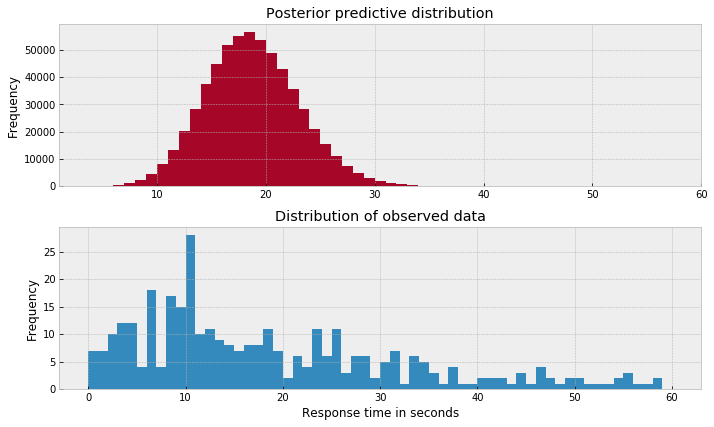

In [16]:
x_lim = 60
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Choosing the right distribution
I'm not particularly happy with the above plot. Ideally, I'd like the posterior predictive distribution to somewhat resemble the distribution of the observed data. Intuitively, if we have correctly estimated the parameters of the model, then we should be able to sample similar data from that model. Clearly this is not the case.

Perhaps the Poisson distribution is not suitable for this data. One alternative option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. Recall that the Poisson distribution has one parameter ($\mu$) that represents both its mean and its variance.

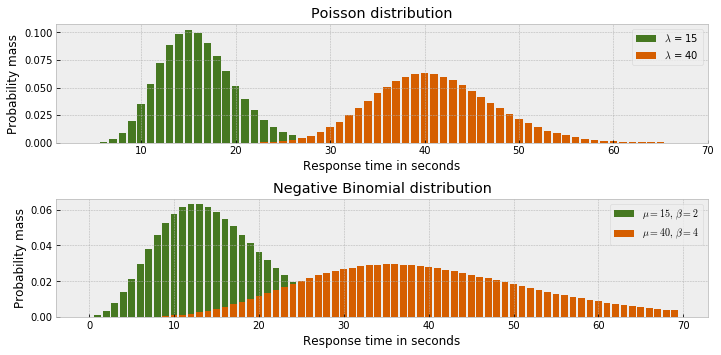

In [17]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1])])

plt.tight_layout()

Lets go ahead and estimate the parameters for a Negative Binomial distribution given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$y_{j} \sim NegBinomial(\mu, \alpha)$$
$$\alpha = Exponential(0.2)$$
$$\mu = Uniform(0,100)$$

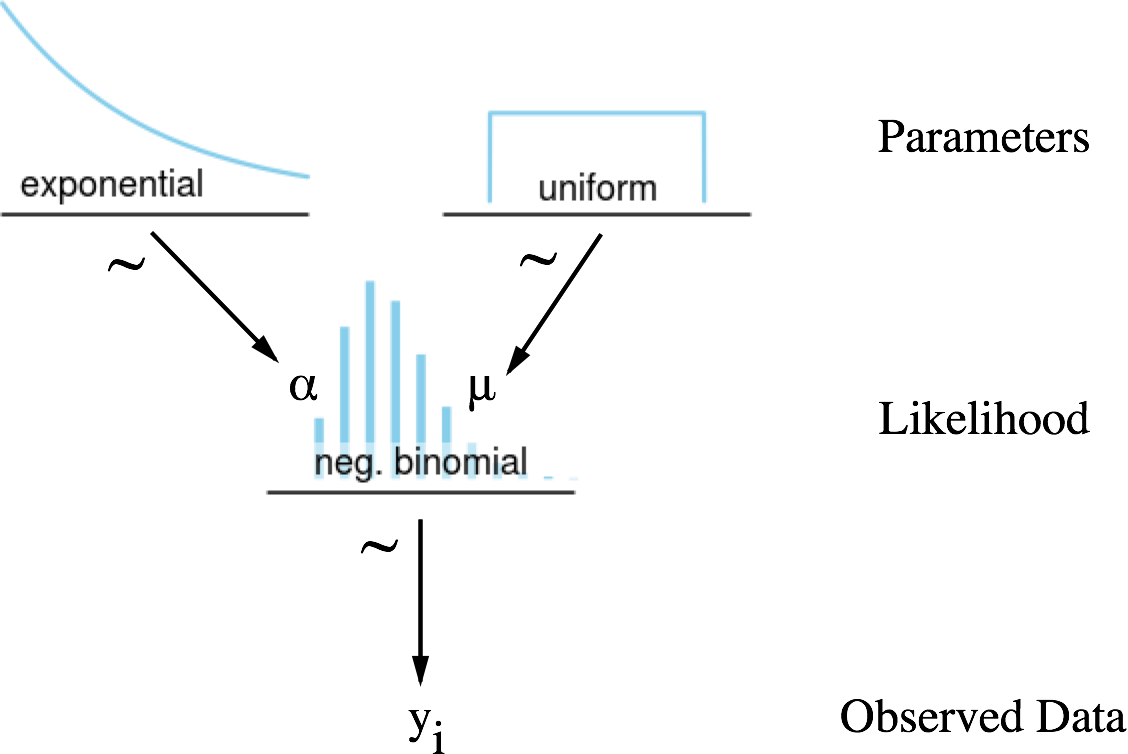

In [18]:
Image('image/Neg Binomial Dag.png', width=400)

In [19]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

logp = -1,756.7, ||grad|| = 589.95: 100%|█████| 11/11 [00:00<00:00, 647.06it/s]


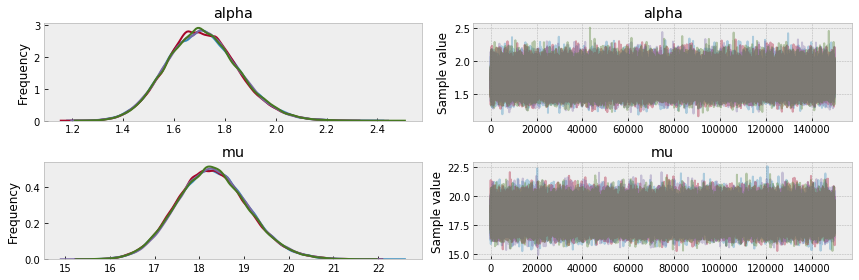

In [20]:
_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

We see the above model has greater uncertainty around the estimation of the mean response time $(\mu)$ for chat messages:
- Poisson: 10 to 30
- Negative Binomial: 16 to 21

Additionally, the Negative Binonomial model has an $\alpha$ parameter of 1.2 to 2.2 which further increases the variance in the estimated parameter $\mu$. Let's have a look at the posterior preditive distribution and see if it more closely resembles the distribution from the observed data.

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


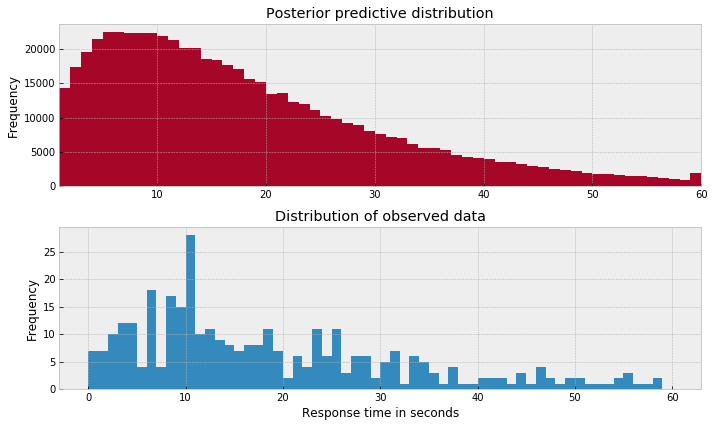

In [21]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Yes, these two distributions are looking more similar to one another. As per the posterior predictive check, this would suggest that the Negative binomial model is a more appropriate fit for the underlying data. 

If you find yourself doubting the rigor of this model checking approach, Bayesians have other, more analytical methods. 

### Model Check II: Bayes Factor
Another modeling technique is to compute the Bayes factor. This is an analytical method that aims to compare two models with each other.

The Bayes factor was typically a difficult metric to compute because it required integrating over the full joint probability distribution. In a low dimension space, integration is possible but once you begin to model in even modest dimensionality, integrating over the full joint posterior distribution becomes computationally costly and time-consuming.

There is an alternative and analogous technique for calculating the Bayes factor. It involves taking your two models for comparison and combining them into a hierarchical model with a model parameter index ($\tau$). This index will switch between the two models throughout the MCMC process depending on which model it finds more credible. As such, the trace of the model index tells us a lot about the credibility of model M1 over model M2.

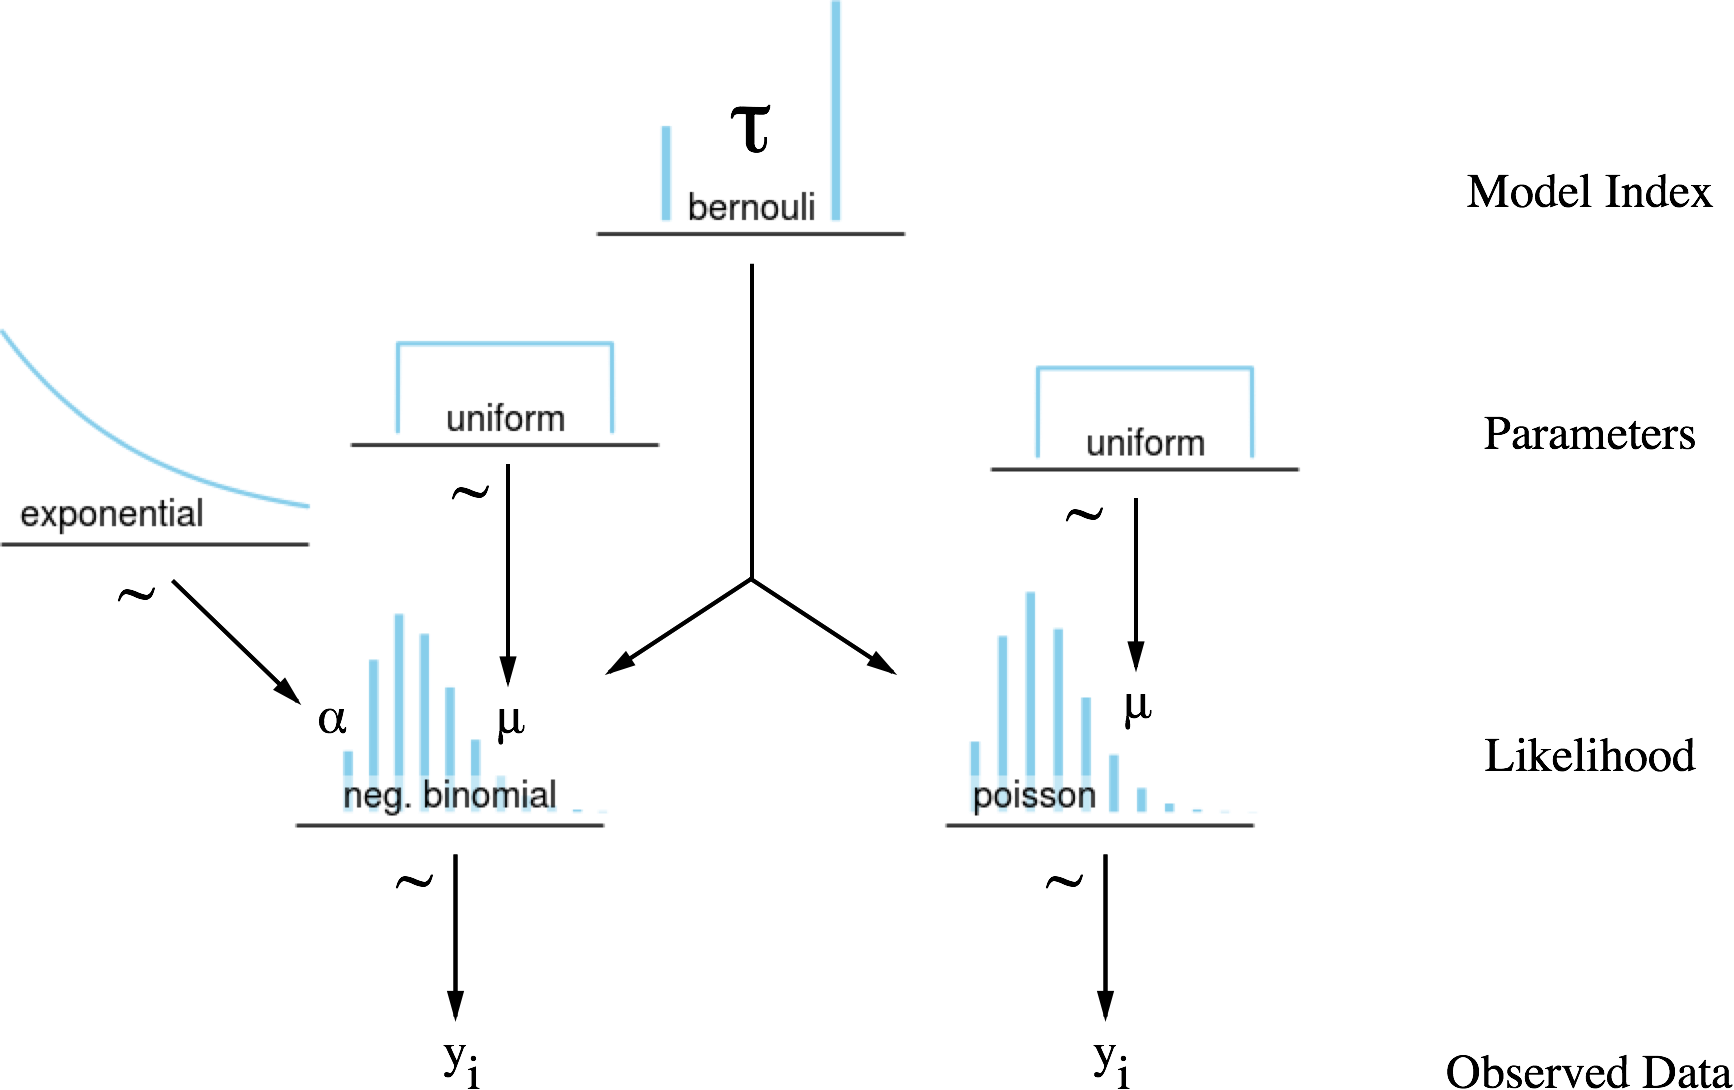

In [22]:
Image('image/Bayes Factor DAG.png', width=540)

logp = -1,468.5, ||grad|| = 295.67: 100%|██████| 8/8 [00:00<00:00, 2666.65it/s]
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|████████████████████████████████| 200500/200500 [02:18<00:00, 1450.12it/s]


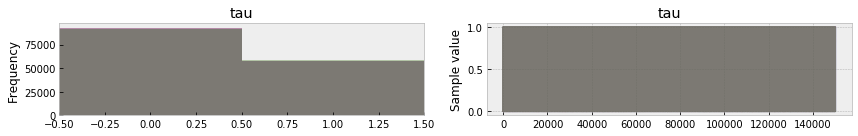

In [23]:
with pm.Model() as model:
    
    # Index to true model
    prior_model_prob = 0.5
    #tau = pm.DiscreteUniform('tau', lower=0, upper=1)
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 60)

    # Negative Binomial parameters
    alpha = pm.Exponential('alpha', lam=0.2)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=60)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.math.switch(tau, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0,1])
    trace = pm.sample(200000, step=[step1, step2], start=start)

_ = pm.traceplot(trace[burnin:], varnames=['tau'])

We can calculate the Bayes Factor for the above two models using the below formulation:

$$Posterior Odds = Bayes Factor * Prior Odds$$

$$\frac{P(Data \ | \ M_{1})}{P(Data \ | \ M_{2})} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$

In the above example, we didn't apply prior probability to either model, hence the Bayes Factor is simply the quotient of the model likelihoods. If you find that your MCMC sampler is not traversing between the two models, you can introduce prior probabilities that will help you get sufficient exposure to both models.

In [24]:
# Compute the Bayes factor
prob_pois = trace[burnin:]['tau'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
print("Bayes Factor: %s" % BF)

Bayes Factor: 1.59609892868


A Bayes Factor of >1 suggests that $M_1$ (Negative Binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.60 as there being weak evidence of $M_1$ over $M_2$ given the data. Combining the posterior predictive check and Bayes factor I will conclude that the Negative Binomial is a better model for the given data.

| Bayes Factor                            | Interpretation                      |
|-----------------------------------------|-------------------------------------|
| BF($M_1, M_2$) < 1/10       | Strong evidence for $M_2$   |
| 1/10 < BF($M_1, M_2$),< 1/3 | Moderate evidence for $M_2$ |
| 1/3 < BF($M_1, M_2$) < 1    | Weak evidence for $M_2$     |
| 1 < BF($M_1, M_2$) < 3      | Weak evidence for $M_1$     |
| 3 < BF($M_1, M_2$) < 10     | Moderate evidence for $M_1$ |
| BF($M_1, M_2$) > 10         | Strong evidence for $M_1$   |

## Part 3: Hierarchal modeling
A key strength of Bayesian modeling is the easy and flexibility with which one can implement a hierarchical model. This section will implement and compare a pooled & partially pooled model.

In [25]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing


%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

D:\Anaconda3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


### Model Pooling
Let's explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that my tendency to reply quickly to a chat depends on who I'm talking to. I might be more likely to respond quickly to my girlfriend than to a distant friend. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for conversations with few messages will have a higher degree of uncertainty than conversations with a large number of messages. The below plot illustrates the discrepancy in sample size per conversation.

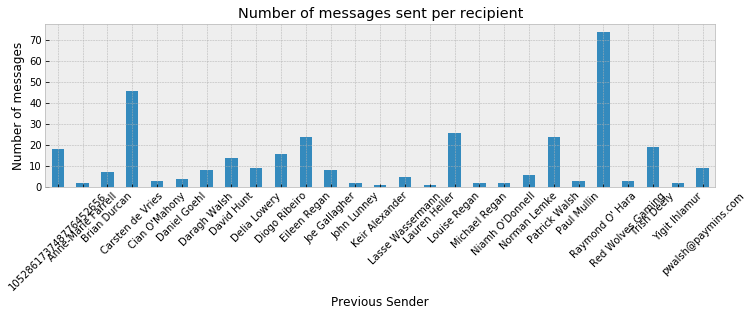

In [26]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient', color=colors[0])
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=45)

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

In [27]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = messages[messages['prev_sender']==p]['time_delay_seconds'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

logp = -81.17, ||grad|| = 1.0932: 100%|██████| 16/16 [00:00<00:00, 2285.72it/s]
logp = -21.485, ||grad|| = 0.018496: 100%|███| 15/15 [00:00<00:00, 2142.79it/s]
logp = -43.369, ||grad|| = 2.6246: 100%|█████| 19/19 [00:00<00:00, 2714.30it/s]
logp = -195.94, ||grad|| = 6.2634: 100%|█████| 18/18 [00:00<00:00, 2571.44it/s]
logp = -25.192, ||grad|| = 0.68771: 100%|████| 18/18 [00:00<00:00, 2000.04it/s]
logp = -29.472, ||grad|| = 0.20681: 100%|████| 16/16 [00:00<00:00, 2285.72it/s]
logp = -46.316, ||grad|| = 0.89041: 100%|████| 17/17 [00:00<00:00, 2428.58it/s]
logp = -71.71, ||grad|| = 1.7701: 100%|██████| 17/17 [00:00<00:00, 2428.58it/s]
logp = -49.282, ||grad|| = 1.3907: 100%|█████| 17/17 [00:00<00:00, 2428.58it/s]
logp = -80.162, ||grad|| = 12.376: 100%|█████| 18/18 [00:00<00:00, 2571.44it/s]
logp = -111.36, ||grad|| = 9.9188: 100%|█████| 18/18 [00:00<00:00, 2250.03it/s]
logp = -69.915, ||grad|| = 50.053: 100%|█████| 19/19 [00:00<00:00, 2714.30it/s]
logp = -20.652, ||grad|| = 0.96448: 100%

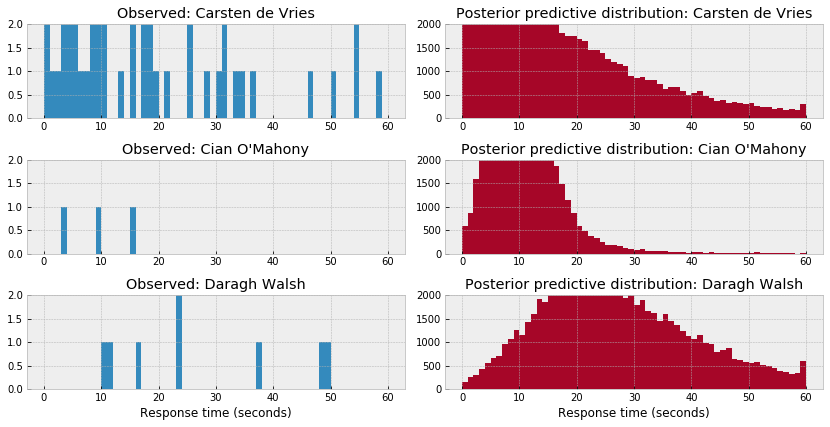

In [28]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 60
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], participants[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. As you can see, the posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be inaccurate due to small sample size.

If we combine the posterior predictive distributions across these models, we would expect this to resemble the distribution of the overall dataset observed. Let's perform the posterior predictive check.

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


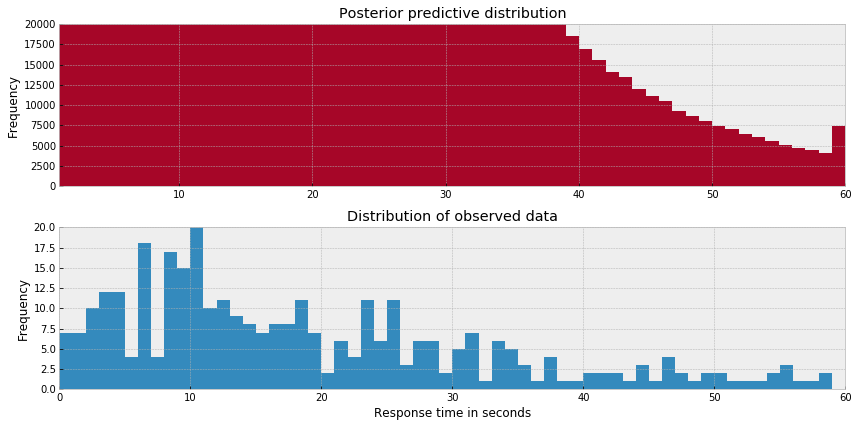

In [29]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Yes, the posterior predictive distribution resembles the distribution of the observed data. However, I'm concerned that some of the conversations have very little data and hence the estimates are likely to have high variance. One way to mitigate this risk to to share information across conversations - but still estimate $\mu_i$ for each conversation. We call this partial pooling.

### Partial pooling
Just like in the pooled model, a partially pooled model has paramater values estimated for each conversation i. However, parameters are connected together via hyperparameters. This reflects our belief that my `response_time`'s per conversation have similarities with one another via my own natural tendancy to respond quickly or slowly.

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$

Following on from the above example, we will estimate parameter values $(\mu_i)$ and $(\alpha_i)$ for a Poisson distribution. Rather than using a uniform prior, I will use a Gamma distribution for both $\mu$ and $\sigma$. This will enable me to introduce more prior knowledge into the model as I have certain expectations as to what vales $\mu$ and $\sigma$ will be.

First, let's have a look at the Gamma distribution. As you can see below, it is very flexible. 

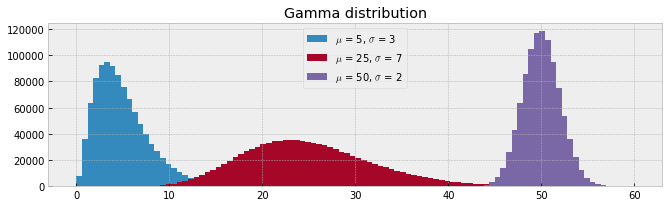

In [30]:
mu = [5,25,50]
sd = [3,7,2]

plt.figure(figsize=(11,3))
_ = plt.title('Gamma distribution')

with pm.Model() as model:
    for i, (j, k) in enumerate(zip(mu, sd)):
        samples = pm.Gamma('gamma_%s' % i, mu=j, sd=k).random(size=10**6)
        plt.hist(samples, bins=100, range=(0,60), color=colors[i], alpha=1)

_ = plt.legend(['$\mu$ = %s, $\sigma$ = %s' % (mu[a], sd[a]) for a in [0,1,2]])

The partially pooled model can be formally described by:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(\mu_\mu, \sigma_\mu)$$
$$\alpha_i = Gamma(\mu_\alpha, \sigma_\alpha)$$
$$\mu_\mu = Uniform(0, 60)$$
$$\sigma_\mu = Uniform(0, 50)$$
$$\mu_\alpha = Uniform(0, 10)$$
$$\sigma_\alpha = Uniform(0, 50)$$

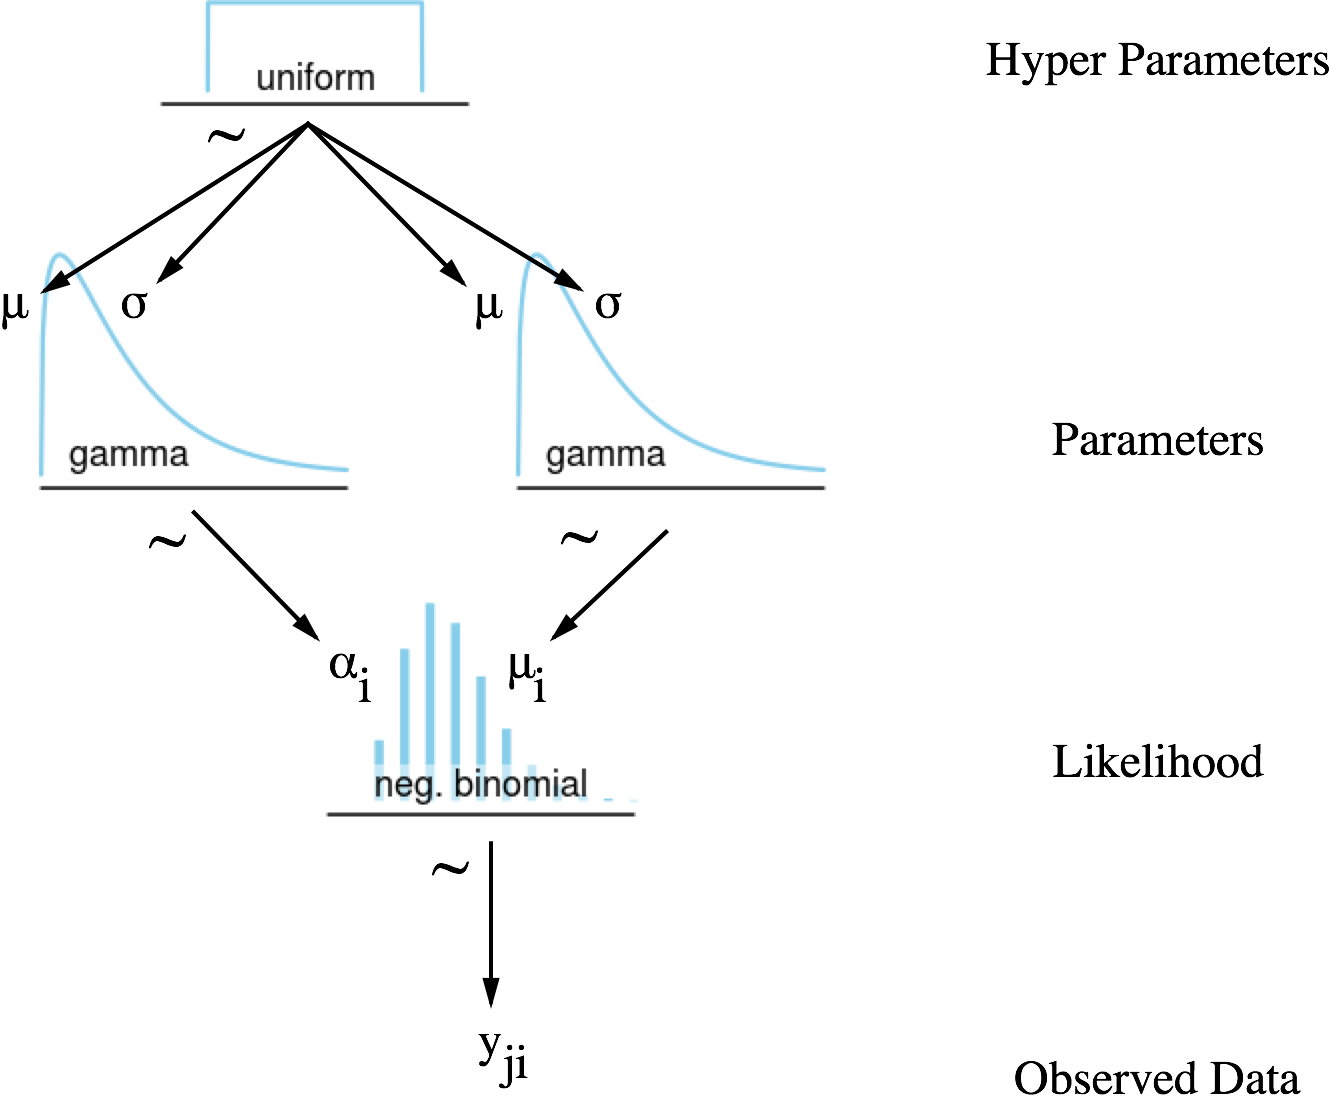

In [31]:
Image('image/dag neg poisson gamma hyper.png', width=420)

In [ ]:
with pm.Model() as model:
    hyper_alpha_sd = pm.Uniform('hyper_alpha_sd', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_sd = pm.Uniform('hyper_mu_sd', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_participants)
    mu = pm.Gamma('mu', mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_participants)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[participants_idx], 
                                alpha=alpha[participants_idx], 
                                observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[participants_idx], 
                                 alpha=alpha[participants_idx],
                                 shape=messages['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(200000, step, progressbar=True)

logp = -2,640.5, ||grad|| = 1,177.5: 100%|█| 217/217 [00:00<00:00, 1364.78it/s] 


In [ ]:
_ = pm.traceplot(hierarchical_trace[120000:], 
                 varnames=['mu','alpha','hyper_mu_mu',
                           'hyper_mu_sd','hyper_alpha_mu',
                           'hyper_alpha_sd'])

You can see for the estimates of $\mu$ and $\alpha$ that we have multiple plots - one for each conversation i. The difference between the pooled and the partially pooled model is that the parameters of the partially pooled model ($\mu_i$ and $\alpha_i$) have a hyperparameter that is shared across all conversations i. This brings two benefits:
1. Information is shared across conversations, so for conversations that have limited sample size, they "borrow" knowledge from other conversations during estimation to help reduce the variance of the estimate
2. We get an estimate for each conversation and an overall estimate for all conversations

Let's have a quick look at the posterior predictive distribution.

In [ ]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred')[::1000].ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchical model
As discussed, the partially pooled model shared a hyperparameter for both $\mu$ and $\alpha$. By sharing knowledge across conversations, it has the effect of shrinking the estimates closer together - particularly for conversations that have little data.

This shrinkage effect is illustrated in the below plot. You can see how the $\mu$ and $\alpha$ parameters are drawn together by the effect of the hyperparameter.

In [ ]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in participants]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in participants]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(5, 45), ylim=(0, 10))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Pooled', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Partially Pooled', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=0)

_ = ax.legend()

### Asking questions of the posterior
Let's start to take advantage of one of the best aspects of Bayesian statistics - the posterior distribution. Unlike frequentist techniques, we get a full posterior distribution as opposed to a single point estimate. In essence, we have a basket full of credible parameter values. This enables us to ask some questions in a fairly natural and intuitive manner.

#### What are the chances I'll respond to my friend in less than 10 seconds?
To estimate this probability, we can look at the posterior predctive distribution for Timothy & Andrew's `response_time` and check how many of the samples are < 10 seconds. When I first heard of this technique, I thought I misunderstood because it seemed overly simplistic. 

In [ ]:
def participant_y_pred(person):
    """Return posterior predictive for person"""
    ix = np.where(participants == person)[0][0]
    return hierarchical_trace['y_pred'][100000:, ix]

In [ ]:
print("Here are some samples from Timothy's posterior predictive distribution: \n %s" % participant_y_pred('Yonas'))

In [ ]:
def person_plotA(person_name):
    ix_check = participant_y_pred(person_name) > 10
    _ = plt.hist(participant_y_pred(person_name)[~ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='<10 seconds')
    _ = plt.hist(participant_y_pred(person_name)[ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='>10 seconds')
    _ = plt.title('Posterior predictive \ndistribution for %s' % person_name)
    _ = plt.xlabel('Response time')
    _ = plt.ylabel('Frequency')
    _ = plt.legend()

def person_plotB(person_name):
    x = np.linspace(1, 60, num=60)
    num_samples = float(len(participant_y_pred(person_name)))
    prob_lt_x = [100*sum(participant_y_pred(person_name) < i)/num_samples for i in x]
    _ = plt.plot(x, prob_lt_x, color=colors[4])
    _ = plt.fill_between(x, prob_lt_x, color=colors[4], alpha=0.3)
    _ = plt.scatter(10, float(100*sum(participant_y_pred(person_name) < 10))/num_samples, s=180, c=colors[4])
    _ = plt.title('Probability of responding \nto %s before time (t)' % person_name)
    _ = plt.xlabel('Response time (t)')
    _ = plt.ylabel('Cumulative probability t')
    _ = plt.ylim(ymin=0, ymax=100)
    _ = plt.xlim(xmin=0, xmax=60)

fig = plt.figure(figsize=(11,6))
_ = fig.add_subplot(221)
person_plotA('Anna')
_ = fig.add_subplot(222)
person_plotB('Anna')

_ = fig.add_subplot(223)
person_plotA('Yonas')
_ = fig.add_subplot(224)
person_plotB('Yonas')

plt.tight_layout()

I find this methodology to be very intuitive and flexible. The plot above left separates the samples from the posterior predictive in terms of being greater than or less than 10 seconds. We can compute the probability by calculating the proportion of samples that are less than 10. The plot on the right simply computes this probability for each response time value from 0 to 60. So, it looks like Anna & Yonas have a 36% & 20% chance of being responded to in less than 10 seconds, respectively.

#### How do my friends pair off against each other?

In [ ]:
def prob_persona_faster(persona, personb):
    return np.float(sum(participant_y_pred(persona) < participant_y_pred(personb)))/len(participant_y_pred(persona))

print("Probability that Tom is responded to faster than Andrew: {:.2%}".format(prob_persona_faster('Anna', 'Yonas')))

In [ ]:
# Create an empty dataframe
ab_dist_df = pd.DataFrame(index=participants, columns=participants, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(participants, 2):
    ab_dist_df.ix[a, b] = prob_persona_faster(a, b)
    
# populate the diagonal
for a in participants:
    ab_dist_df.ix[a, a] = 0.5

In [ ]:
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap)
_ = plt.title('Probability that Person A will be responded to faster than Person B')
_ = plt.ylabel('Person A')
_ = plt.xlabel('Person B')

## Part 4: Bayesian Regression

Previously, we addressed the question: "is my chat response time effected by who I'm talking to?". We have estimated model parameters for each individual I've had conversations with. But sometimes we want to understand the effect of more factors such as "day of week," "time of day," etc. We can use GLM (generalized linear models) to better understand the effects of these factors.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Linear regression reminder

When we have a response $y$ that is continuous from $-\infty$ to $\infty$, we can consider using a linear regression represented by: 

$$y \sim \mathcal{N}(\mu, \sigma)$$
$$\mu = \beta_0 + \beta_1 X_1 ... \beta_n X_n$$

We read this as: our response is normally distributed around $\mu$ with a standard deviation of $\sigma$. The value of $\mu$ is described by a linear function of explanatory variables $X \beta$ with a baseline intercept $\beta_0$.

### Link functions

In the event you're not modeling a continuous response variable from $-\infty$ to $\infty$, you may need to use a link function to transform your response range. For a Poisson distribution, the canonical link function used is the log link. This can be formally described as:

$$y \sim Poi(\mu)$$
$$log(\mu) = \beta_0 + \beta_1 X_1 ... \beta_n X_n$$
$$\mu = e^{(\beta_0 + \beta_1 X_1 ... \beta_n X_n)}$$

This is considered to be a fixed effects model. The $\beta$ coefficients are estimated across the entire population as opposed to estimating separate parameters for each person (like in the pooled and partially pooled model in Section 3).

### Fixed effects Poisson regression

To construct a Poisson regression in PyMC3, we need to apply the log link function to $\mu$.  The underlying data model in PyMC3 uses theano and hence we need to use the theano tensor method `theano.tensor.exp()` as shown below.

In [ ]:
X = messages[['is_weekend','day_of_week','message_length','num_participants']].values
_, num_X = X.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_message_length = pm.Normal('beta_message_length', mu=0, sd=100)
    beta_is_weekend = pm.Normal('beta_is_weekend', mu=0, sd=100)
    beta_num_participants = pm.Normal('beta_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept 
                + beta_message_length*messages.message_length 
                + beta_is_weekend*messages.is_weekend
                + beta_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

As you can see from the above results, the baseline intercept $\beta_0$ has an estimated value of between 2.5 and 2.9. So what does this mean?

Unfortunately, interpreting the parameters of a Poisson regression is more involved than a simple linear regression (y = $\beta$ x). In this linear regression, we could say for every unit increase in x, $\hat{y}$ increases by $\beta$. However, in the Poisson regression we need to consider the link function. The [following cross validated post](http://stats.stackexchange.com/questions/128926/how-to-interpret-parameter-estimates-in-poisson-glm-results) explains in great detail how we arrive at the below formulation.

> For a Poisson model, given a unit change in $x$, the fitted $\hat y$ changes by $\hat y \left( e^\beta - 1 \right)$

The main takeaway from this is that the effect of changing x depends on the current value of y. Unlike the simple linear regression, a unit change in x does not cause a consistent change in y.

###  Marginal and pairwise density plots

The below plot shows the marginal densities (across the diagonal) and the pairwise densities (lower and upper panes). This plot is very useful for understanding how covariates interact with one another. In the above example, we can see that as the number of participants increases, the baseline intercept decreases. 

In [ ]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})

### Mixed effects poisson regression

We can make a small extension to the above model by including a random intercept parameter. This will allow us to estimate a baseline parameter value $\beta_0$ for each person I communicate with. For all other parameters I will estimate a parameter across the entire population. For each person i and each message j, this is formally represented as:

$$y_{ji} \sim Poi(\mu)$$
$$\mu = \beta_{0_i} + \beta_1 x_1 ... \beta_n x_n$$

By introducing this random effects parameter $\beta_0$ for each person i, it allows the model to establish a different baseline for each person responded to - whilst estimating the  effects of the covariates on the response for the entire population.

In [ ]:
# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope_message_length = pm.Normal('slope_message_length', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_num_participants = pm.Normal('slope_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept[participants_idx] 
                + slope_message_length*messages.message_length 
                + slope_is_weekend*messages.is_weekend
                + slope_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

The interpretation of the above results are interesting:
- Each person has a different baseline response rate (as shown in the pooled and partially pooled model in Section 3)
- Longer messages take marginally longer to respond to
- You are more likely to get a slow response if you message me on the weekend
- I tend to reply more quickly to conversations that have multiple people added to it (group  chat)

And after accounting for the effect of each covariate on the response, the model estimates the below $\beta_0$ parameters.

In [ ]:
_ = plt.figure(figsize=(5, 6))
_ = pm.forestplot(trace[20000:], varnames=['intercept'], ylabels=participants)